In [1]:
from standards import *

In [2]:
x = np.linspace(-100, 100, 201)
groundTruth = 3 * np.exp(-1* (x - 20)**2/40**2) + 0.01*x

In [3]:
def cutOneDimDataIntoKacheln(x, values, numKacheln):
    cuts = [int((i+1) * len(x)/numKacheln) for i in range(numKacheln-1)]
    boundsIndices = [0] + cuts + [len(x)]
    centers = [np.mean(x[boundsIndices[i]:boundsIndices[i+1]]) for i in range(numKacheln)]
    kachelValues = [np.mean(values[boundsIndices[i]:boundsIndices[i+1]]) for i in range(numKacheln)]
    
    centers = np.asarray(centers)
    kachelValues = np.asarray(kachelValues)
    boundsIndices = np.asarray(boundsIndices)
    
    fullValueArray = np.zeros(x.shape)
    print(boundsIndices)
    for i in range(len(boundsIndices)-1):
        fullValueArray[boundsIndices[i]:boundsIndices[i+1]] = kachelValues[i]
    
    return centers, kachelValues, fullValueArray

########

def vectorizedBarnes(x, points_x, points_y, kacheln_x, kacheln_y, kappa_point = None, kappa_kachel = None, relKachelWeight = None):
    points_x = np.asarray(points_x)
    points_y = np.asarray(points_y)
    kacheln_x = np.asarray(kacheln_x)
    kacheln_y = np.asarray(kacheln_y)
    
    if kappa_point == None:
        kappa_point = 20**2
    if kappa_kachel == None:
        kappa_kachel = 200**2
    if relKachelWeight == None:
        relKachelWeight = 0.2
    
    #weights: shape: (number of points, gridpoints)
    #probably could be optimized
    weightsPoints = np.asarray([np.exp(-1 * (x-xpos)**2/kappa_point) for xpos in points_x])
    weightsKacheln = np.asarray([relKachelWeight * np.exp(-1 * (x-xpos)**2/kappa_kachel) for xpos in kacheln_x])
    
    #multiply weights correctly with the measured values
    weightedPointValues = np.matmul(np.diag(points_y), weightsPoints)
    summedWeightedPointValues = np.sum(weightedPointValues, axis = 0)
    weightedKachelValues = np.matmul(np.diag(kacheln_y), weightsKacheln)
    summedWeightedKachelValues = np.sum(weightedKachelValues, axis = 0)
    
    #first pass Barnes Interpolation
    interpol = (summedWeightedPointValues + summedWeightedKachelValues)/ (np.sum(weightsPoints, axis = 0) + np.sum(weightsKacheln, axis = 0))
    
    return interpol

[  0  67 134 201]


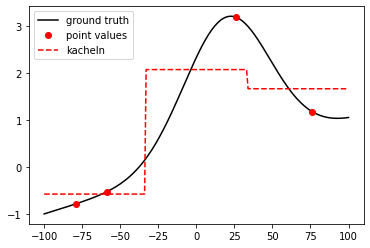

In [4]:
indices = [21, 41, 126, 176]
points_x = [x[ind] for ind in indices]
points_y = [groundTruth[ind] for ind in indices]

numKacheln = 3
kachelCenter, kachelValues, fullValueArray = cutOneDimDataIntoKacheln(x, groundTruth, numKacheln)

plt.plot(x, groundTruth, color = 'k', label = 'ground truth')
plt.plot(points_x, points_y, color = 'r', ls = '', marker = 'o', label = 'point values')
plt.plot(x, fullValueArray, color = 'r', ls = '--', label = 'kacheln')
plt.legend()

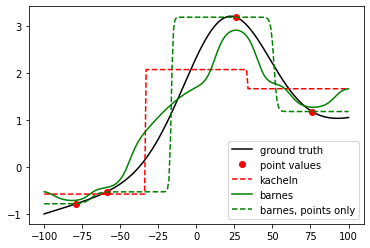

In [20]:
kappaPoints = 10**2
kappaKacheln = 50**2
relKachelWeight = 0.2
interpolation = vectorizedBarnes(x, points_x, points_y, kachelCenter, kachelValues, kappa_point = kappaPoints, kappa_kachel = kappaKacheln, relKachelWeight = relKachelWeight)
interpolation_pointsOnly = vectorizedBarnes(x, points_x, points_y, [], [], kappa_point = kappaPoints, kappa_kachel = kappaKacheln, relKachelWeight = relKachelWeight)


plt.plot(x, groundTruth, color = 'k', label = 'ground truth')
plt.plot(points_x, points_y, color = 'r', ls = '', marker = 'o', label = 'point values')
plt.plot(x, fullValueArray, color = 'r', ls = '--', label = 'kacheln')
plt.plot(x, interpolation, color = 'g', label = 'barnes')
plt.plot(x, interpolation_pointsOnly, color = 'g', ls = '--', label = 'barnes, points only')
plt.legend()

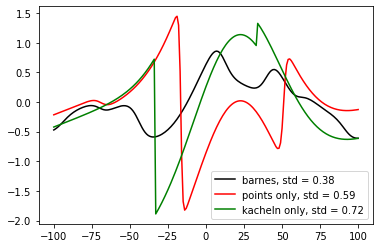

In [21]:
residualInterpolation = groundTruth - interpolation
residualPointsOnly = groundTruth - interpolation_pointsOnly
residualKacheln = groundTruth - fullValueArray
stdInter = np.std(residualInterpolation)
stdPointsOnly = np.std(residualPointsOnly)
stdKachelnOnly = np.std(residualKacheln)

plt.plot(x, residualInterpolation, color = 'k', label = 'barnes, std = '+str(round(stdInter, 2)))
plt.plot(x, residualPointsOnly, color = 'r', label = 'points only, std = '+str(round(stdPointsOnly, 2)))
plt.plot(x, residualKacheln, color = 'g', label = 'kacheln only, std = '+str(round(stdKachelnOnly, 2)))
plt.legend()

In [ ]:
def secondPassBarnes(x, points_x, points_y, kacheln_x, kacheln_y, kappa_point = None, kappa_kachel = None, relKachelWeight = None, gamma = None):
    points_x = np.asarray(points_x)
    points_y = np.asarray(points_y)
    kacheln_x = np.asarray(kacheln_x)
    kacheln_y = np.asarray(kacheln_y)
    
    if kappa_point == None:
        kappa_point = 20**2
    if kappa_kachel == None:
        kappa_kachel = 200**2
    if relKachelWeight == None:
        relKachelWeight = 0.2
    
    #weights: shape: (number of points, gridpoints)
    #probably could be optimized
    weightsPoints = np.asarray([np.exp(-1 * (x-xpos)**2/kappa_point) for xpos in points_x])
    weightsKacheln = np.asarray([relKachelWeight * np.exp(-1 * (x-xpos)**2/kappa_kachel) for xpos in kacheln_x])
    
    #multiply weights correctly with the measured values
    weightedPointValues = np.matmul(np.diag(points_y), weightsPoints)
    summedWeightedPointValues = np.sum(weightedPointValues, axis = 0)
    weightedKachelValues = np.matmul(np.diag(kacheln_y), weightsKacheln)
    summedWeightedKachelValues = np.sum(weightedKachelValues, axis = 0)
    
    #first pass Barnes Interpolation
    interpol = (summedWeightedPointValues + summedWeightedKachelValues)/ (np.sum(weightsPoints, axis = 0) + np.sum(weightsKacheln, axis = 0))
    
    return interpol